# Unsupervised Algorithms Final Project
## Predicting Fake Tweets with FakeNewsNet Data

The dataset has 21724 distinct tweet titles. The data consists of tweet titles, URLs, tweet source_domains, number of retweets, and the identifier as real/unreal (0/1).
<br>
<br>
The goal is to used the text from the tweet titles and the domain name to predict the validitiy of the tweet content. Similar to the week 4 project, I will be using NLP tools and bag of words processes to model the text. I will then vectorize the text and make predictions based upon content words and meaning.
<br>
<br>
There are only two categories to be assigned: 1 and 0. The integer 1 will denote a valide tweet and 0 will denote fake tweets. 

In [85]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import string
import seaborn as sns
from sklearn.decomposition import NMF
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.utils import simple_preprocess
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering, KMeans

## Import and Inspect Data
### I will perform EDA before splitting the dataset into train/test portions

I will explore:
- Dimensions of the data
- Na's and unique values
- Check for duplicate data

In [86]:
df = pd.read_csv('FakeNewsNet.csv')


In [87]:
print("+ Shape is: ", df.shape)
 
print("+ Number of na values: ", df.isna().sum())
 
print("+ Data types: ", df.dtypes)
 
print("+ Unique value counts: ", df.nunique())
 
print("+ Number of unique categories: ", df.real.unique())
 
print("+ Text duplicates in the data: " ,df.duplicated(subset = ['title']).sum())

+ Shape is:  (23196, 5)
+ Number of na values:  title              0
news_url         330
source_domain    330
tweet_num          0
real               0
dtype: int64
+ Data types:  title            object
news_url         object
source_domain    object
tweet_num         int64
real              int64
dtype: object
+ Unique value counts:  title            21724
news_url         21658
source_domain     2441
tweet_num          825
real                 2
dtype: int64
+ Number of unique categories:  [1 0]
+ Text duplicates in the data:  1472


### Post EDA
<br>
The data contained 1472 duplicate titles. I will remove duplicate titles before analysis. The domain will be added to the title text so that it can be processed and vectorized along with the title data and analyzed as a word.
<br>
<br>
The data will be split into 75% training and 25% testing.

In [88]:
df = df.drop_duplicates(subset = 'title')
df['title'] = df['title'] + ' ' + df['source_domain']

In [89]:
df.title[0]

"Kandi Burruss Explodes Over Rape Accusation on 'Real Housewives of Atlanta' Reunion (Video) toofab.com"

In [90]:
df_X = df[['title']]
df_y = df[['real']]

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size = 0.25, random_state = 42)

In [91]:
X_train.title = X_train.title.astype(str)
X_test.title = X_test.title.astype(str)

c:\users\trahajo\appdata\local\programs\python\python38\lib\site-packages\pandas\core\generic.py:5491: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Word Count Visualization and LNP Processes

Establish lemmatizer and stopwords for removal using NLTK. Define a word counting fuctions and create histogram of word counts. This step will assist with hyperparameter tuning in future steps

In [92]:
stopwords = nltk.corpus.stopwords.words('english')
wnl = nltk.WordNetLemmatizer()

In [93]:
def count_words(text):
    return len(str(text).split(' '))
   
df['w_count'] = df['title'].apply(count_words)

Text(0.5, 1.0, 'Word Count Distribution')

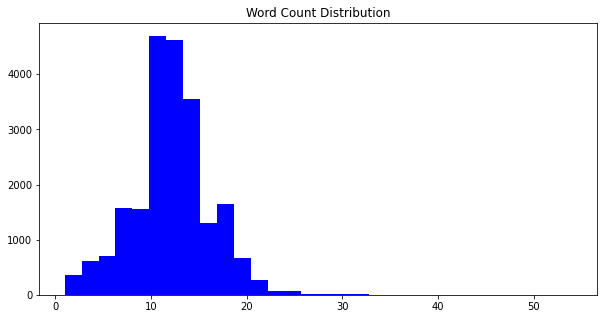

In [94]:
fig = plt.figure(figsize = (10,5))
 
plt.hist(df['w_count'], bins=30, color = "blue")
 
plt.title('Word Count Distribution')

## Clean documents and find the most frequent words in the documents

Text cleaning removes any punctuation and stopwords (words that will not be significant during analysis). I will create a list of words per text that will be most meaningful. Lemmmatization will provide a list of root words and will remove features such as tense and plurality.

In [95]:
def cleantext(text):
    text = "".join([word for word in text if word not in string.punctuation])
    words = re.split('\W+', text)
    text = [wnl.lemmatize(word) for word in words if word not in stopwords]
    return text
   
X_train['proc_words'] = X_train.title.apply(cleantext)
X_train['proc_words1'] = X_train.title.apply(simple_preprocess)

X_test['proc_words'] = X_test.title.apply(cleantext)
X_test['proc_words1'] = X_test.title.apply(simple_preprocess)

df['proc_words'] = df.title.astype(str).apply(cleantext)


<ipython-input-95-bece70aaf5f4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['proc_words'] = X_train.title.apply(cleantext)
<ipython-input-95-bece70aaf5f4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['proc_words1'] = X_train.title.apply(simple_preprocess)
<ipython-input-95-bece70aaf5f4>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [96]:
X_train

,title,proc_words,proc_words1
5435,"Milo Ventimiglia on Jack's 'This Is Us' death,...","[Milo, Ventimiglia, Jacks, This, Is, Us, death...","[milo, ventimiglia, on, jack, this, is, us, de..."
9595,Luann D'Agostino and Tom D'Agostino Shut Down ...,"[Luann, DAgostino, Tom, DAgostino, Shut, Down,...","[luann, agostino, and, tom, agostino, shut, do..."
16291,Keeping Up With the Kardashians announces mara...,"[Keeping, Up, With, Kardashians, announces, ma...","[keeping, up, with, the, kardashians, announce..."
943,Jennifer Garner & Josh Duhamel Dating: Why Ben...,"[Jennifer, Garner, Josh, Duhamel, Dating, Why,...","[jennifer, garner, josh, duhamel, dating, why,..."
8807,"Kanye West returns to Twitter, gets sentimenta...","[Kanye, West, return, Twitter, get, sentimenta...","[kanye, west, returns, to, twitter, gets, sent..."
...,...,...,...
12487,The Second Wave of 2017 Teen Choice Awards Nom...,"[The, Second, Wave, 2017, Teen, Choice, Awards...","[the, second, wave, of, teen, choice, awards, ..."
23036,Fans are dragging Selena Gomez for supporting ...,"[Fans, dragging, Selena, Gomez, supporting, bu...","[fans, are, dragging, selena, gomez, for, supp..."
5513,Rosie O'Donnell Responds to 'Vengeful Child' C...,"[Rosie, ODonnell, Responds, Vengeful, Child, C...","[rosie, donnell, responds, to, vengeful, child..."
868,They Didn't Mean It Like That: Actors Defendin...,"[They, Didnt, Mean, It, Like, That, Actors, De...","[they, didn, mean, it, like, that, actors, def..."


In [97]:
p_w = df.proc_words.to_numpy().flatten()
 
def u_word_count(df):
    w_dict = {}
    for r in df.proc_words:
        for word in r:
            if word not in w_dict.keys():
                w_dict[word] = 1
            w_dict[word] +=1
    return w_dict
 
u_word_counts = u_word_count(df)
w_df = pd.DataFrame.from_dict(u_word_counts, orient = 'index', columns = ['frequency']).reset_index()
 
tw_df = w_df.sort_values(by = ['frequency'], ascending = False)[0:20]

<AxesSubplot:xlabel='index', ylabel='frequency'>

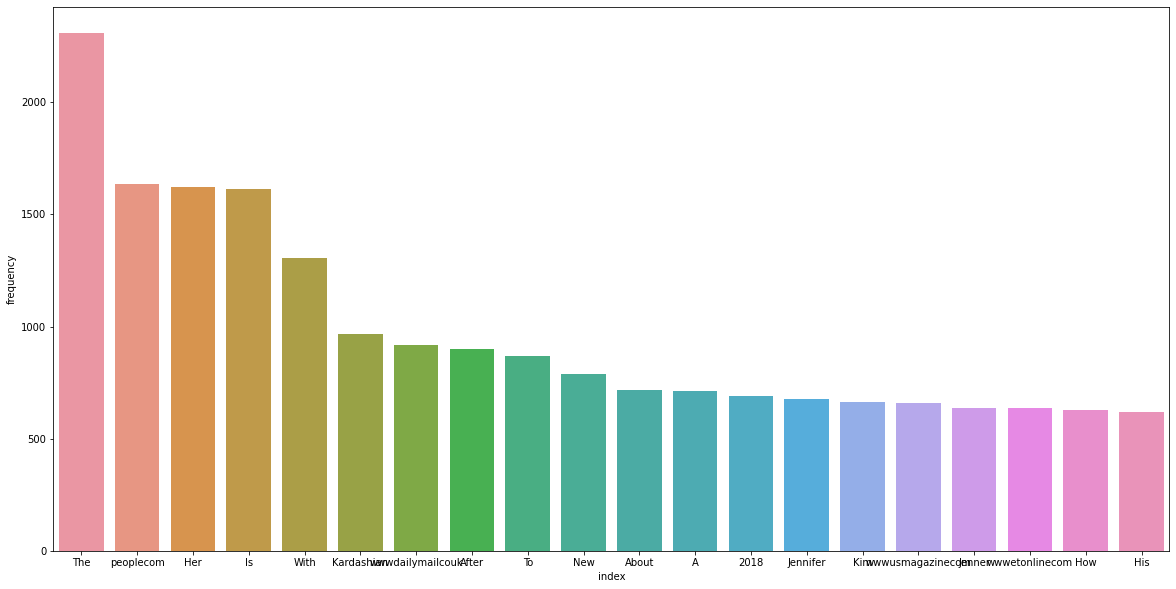

In [98]:
plt.figure(figsize = (20,10))
sns.barplot(x = 'index', y = 'frequency', data = tw_df)

## Create Bag of Words and Vectorized the documents

Use gensim to create a bag of words. The dictionary will assign words to their meaning via unique integer assignment. For each text there will be a "bag of words" and their meanings to apply to topical analysis. TFIDF will transform the bag of words into a vector form for use within the algorithms. 

In [99]:
docs = X_train['proc_words']
docs_test = X_test.proc_words
 
dictionary = Dictionary(docs)
dictionary_test = Dictionary(docs_test)

corp = [dictionary.doc2bow(doc, allow_update = True) for doc in docs]
corp_test = [dictionary.doc2bow(doc, allow_update = True) for doc in docs_test]

#### Note
<br>
By using max_df I can help decide word importance by elimating words that appear in 80% of documents as I have done below. Also, I can manage words that appear a minimum number of times, such as 6, per text. Max_features allows me to reduce the number of features (words) that are used to train the algorithm

In [100]:
tfidf = TfidfVectorizer(max_df = 0.5, min_df = 10, max_features = 2500, preprocessor = ' '.join)
 
tf = tfidf.fit_transform(docs)
tf_test = tfidf.transform(docs_test)

## NonNegative Matrix Factorization

Use sklearn.decomposition to access the NMF() method. The initialization of the method with 'nndsvd' was chose due to the sparse nature of the data. Since it is known how many categories exist, n_components was set to 2. Alpha helps control the regularization of the data.

In [101]:
nmf = NMF(
    n_components=2,
    init='nndsvd',
    alpha = 1,
    random_state = 1029,
    max_iter = 1000
).fit(tf)

In [102]:
H = nmf.transform(tf_test)
W = nmf.components_

In [103]:
pubs = X_test.index.tolist()

topic = H.argmax(axis = 1)

preds = pd.DataFrame({'articles': pubs, 'preds': topic})

In [104]:
preds

,articles,preds
0,9856,1
1,5061,1
2,14857,1
3,6840,1
4,567,1
...,...,...
5426,5485,1
5427,17175,1
5428,21143,1
5429,9018,1


## Accuracy and RSME

In [105]:
accuracy_score(y_test, preds.preds)

0.7652366046768551

## Analysis of the Confusion Matrix
<br>
The precision, or True Negative Rate, was the best performing metric at 99%. If the model tells a reader that the tweet is not spam, then very reliable.
<br>
The worst performing metric is the Recall or True Positive Rate. The model often labels tweets as fake that are not. The accuracy score for the testing data is around 77%. The recommendation for the model given the analysis as a whole is that it is a great model to inform readers of certified real tweets.

In [106]:
confusion_matrix(y_test, preds.preds)

array([[  79, 1233],
       [  42, 4077]], dtype=int64)